In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.cluster import hierarchy as hierarchy_lib
from datetime import datetime as time
import random

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import train_test_split
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN

In [60]:
from sklearn.preprocessing import StandardScaler

def preprocess_data(data, drop_columns=None):
    if drop_columns:
        data = data.drop(columns=drop_columns)
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data.select_dtypes(include=[np.number]))
    return scaled_data

In [61]:
data_iris = pd.read_csv("iris.csv")
data_iris.drop_duplicates()
data_iris = data_iris.drop(columns=["species"], axis = 1)
data_iris.head(5)

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


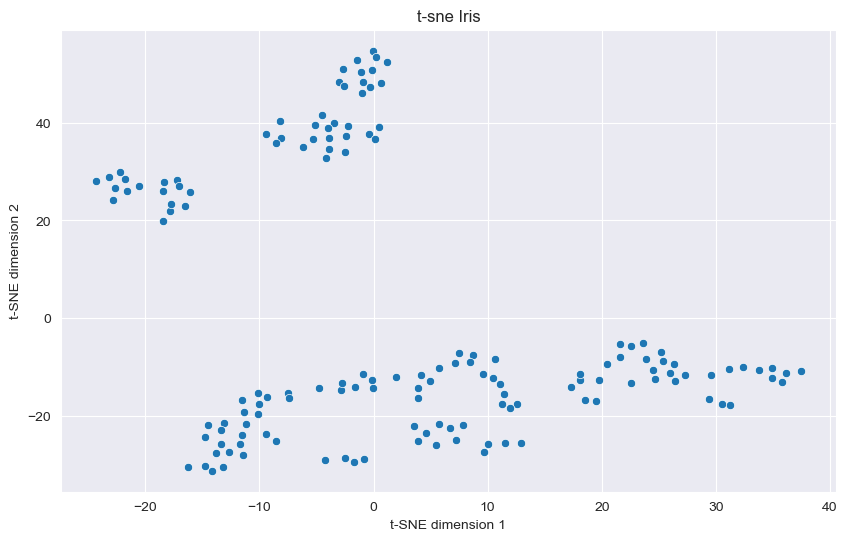

In [62]:
data_iris_scaled = preprocess_data(data_iris)

data_iris_tsne = TSNE(n_components=2, learning_rate=200, perplexity=10).fit_transform(X=data_iris_scaled)

data_iris_tsne_df = pd.DataFrame(data = data_iris_tsne, columns = ["Dimension1", "Dimension2"])
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_iris_tsne_df, x='Dimension1', y='Dimension2')
plt.title('t-sne Iris')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.show()

Text(0, 0.5, 'PCA dimension 2')

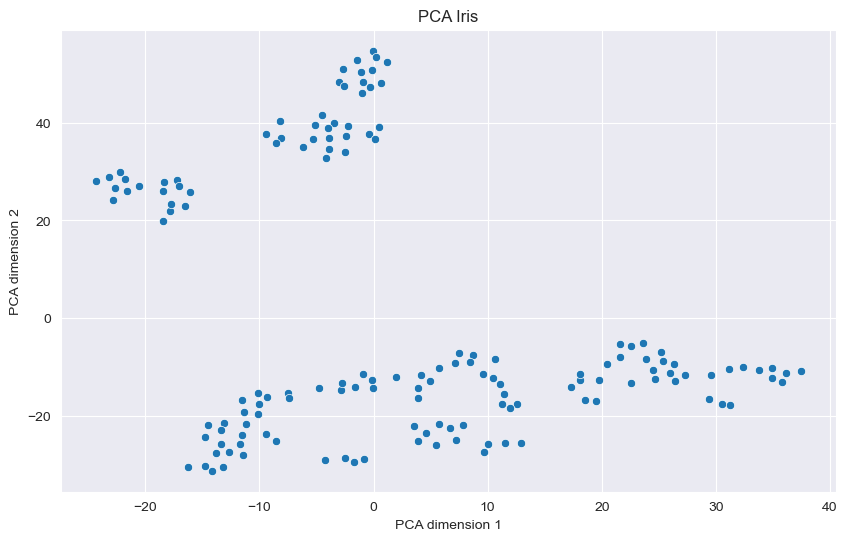

In [63]:
data_iris_pca = PCA(n_components=2).fit_transform(data_iris_scaled)

data_iris_pca_df = pd.DataFrame(data = data_iris_pca, columns = ["Dimension1", "Dimension2"])
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_iris_tsne_df, x='Dimension1', y='Dimension2')
plt.title('PCA Iris')
plt.xlabel('PCA dimension 1')
plt.ylabel('PCA dimension 2')

In [64]:
data_mall = pd.read_csv("Mall_Customers.csv")
data_mall["Gender"] = np.where(data_mall["Gender"] == "Male", 1, 0)
data_mall.head(5)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,1,19,15,39
1,2,1,21,15,81
2,3,0,20,16,6
3,4,0,23,16,77
4,5,0,31,17,40


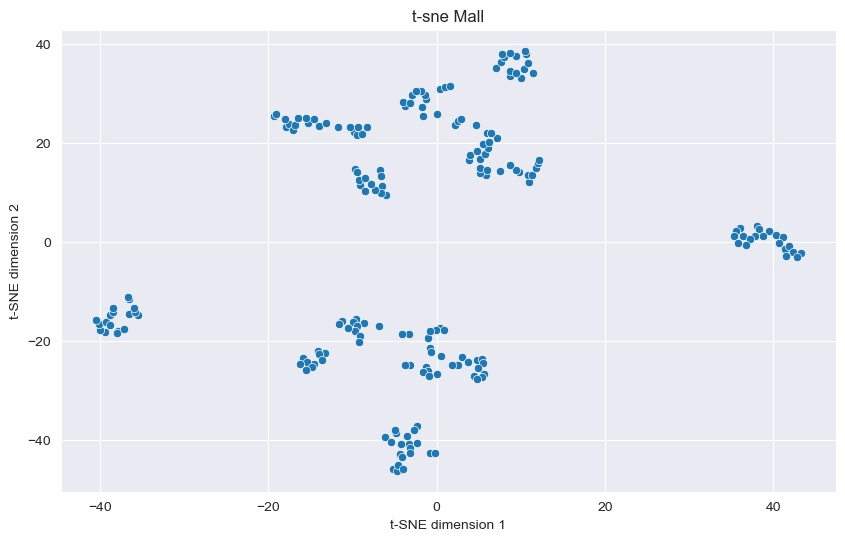

In [65]:
data_mall_scaled = preprocess_data(data_mall)

data_mall_tsne = TSNE(n_components=2, learning_rate=200, perplexity=10).fit_transform(X=data_mall_scaled)

data_mall_tsne_df = pd.DataFrame(data = data_mall_tsne, columns = ["Dimension1", "Dimension2"])
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_mall_tsne_df, x='Dimension1', y='Dimension2')
plt.title('t-sne Mall')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.show()

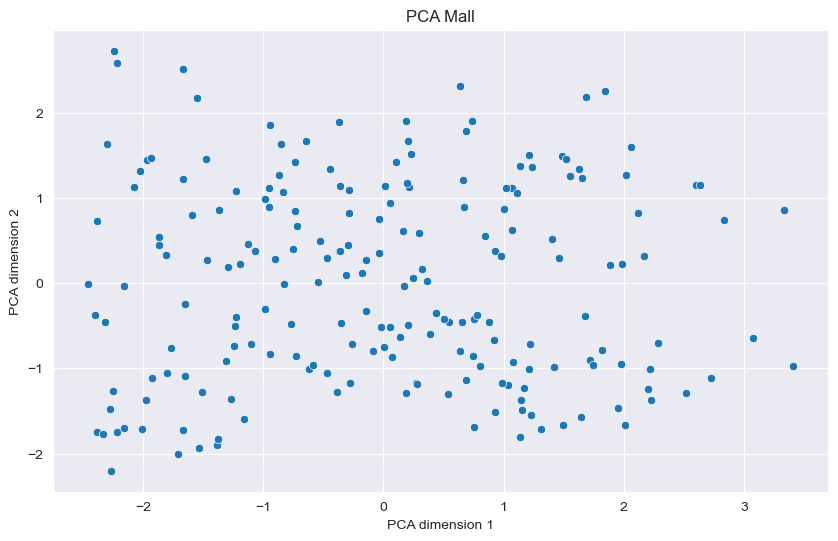

In [66]:
data_mall_pca = PCA(n_components=2).fit_transform(data_mall_scaled)

data_mall_pca_df = pd.DataFrame(data = data_mall_pca, columns = ["Dimension1", "Dimension2"])
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_mall_pca_df, x='Dimension1', y='Dimension2')
plt.title('PCA Mall')
plt.xlabel('PCA dimension 1')
plt.ylabel('PCA dimension 2')
plt.show()

## Метрики

In [67]:
from scipy.spatial.distance import cdist


def inner_cluster_distance(data, labels):
    distances = []
    unique_labels = np.unique(labels)
    for label_a in unique_labels:
        for label_b in unique_labels:
            if label_b > label_a:
                cluster_a = data[labels == label_a]
                cluster_b = data[labels == label_b]
                distance = (
                        np.sum(cdist(cluster_a, cluster_b)) *
                        len(cluster_a) * len(cluster_b) /
                        (len(cluster_a) + len(cluster_b))
                )
                distances.append(distance)
    return np.mean(distances)


def outer_cluster_distance(data, labels):
    distances = []
    unique_labels = np.unique(labels)

    for label in unique_labels:
        cluster_points = data[labels == label]
        cluster_center = np.mean(cluster_points, axis=0).reshape(1, -1)
        intra_distance = np.sum(cdist(cluster_points, cluster_center))
        distances.append(intra_distance)

    return np.mean(distances)


def metrics_compairson(dataset, l1, l2, timers):
    fig, axes = plt.subplots(figsize=(8, 3))
    x = ['Native', 'Scipy']
    bar_colors = ['tab:green', 'tab:blue']
    axes.bar(x, timers, color=bar_colors)
    axes.set_title("Time, ms")
    plt.show()

    fig, axes = plt.subplots(figsize=(8, 3))
    x = ['Native', 'Scipy']
    bar_colors = ['tab:green', 'tab:blue']
    axes.bar(x, [inner_cluster_distance(dataset, l1), inner_cluster_distance(dataset, l2)], color=bar_colors)
    axes.set_title("Intercluster distance")
    plt.show()


    fig, axes = plt.subplots(figsize=(8, 3))
    x = ['Native', 'Scipy']
    bar_colors = ['tab:green', 'tab:blue']
    axes.bar(x, [outer_cluster_distance(dataset, l1), outer_cluster_distance(dataset, l2)], color=bar_colors)
    axes.set_title("Intracluster distance")
    plt.show()


def plot_clusters(y, pca_df, title):
    plt.figure(figsize=(5, 3))
    plt.scatter(pca_df["Dimension1"], pca_df["Dimension2"], c=y, cmap="viridis", edgecolors="k")
    plt.xlabel("Dimension1")
    plt.ylabel("Dimension2")
    plt.title(title)
    plt.show()

## Иерархическая Кластеризация

In [68]:
def init_hierarchial(data):
    num_elements = len(data)
    cluster_sizes = list(np.ones(num_elements, dtype=np.int64))
    cluster_indices = list(range(num_elements))
    cluster_distances = {}
    all_cluster_sizes = {c_id: size for c_id, size in zip(cluster_indices, cluster_sizes)}
    return num_elements, cluster_sizes, cluster_indices, cluster_distances, all_cluster_sizes

def calculate_distance_matrix(data):
    distance_matrix = np.sqrt(np.sum((data[:, None] - data[None, :]) ** 2, axis=2))
    np.fill_diagonal(distance_matrix, np.inf)
    return distance_matrix

def find_closest_clusters(distance_matrix):
    min_idx = np.argmin(distance_matrix)
    return np.unravel_index(min_idx, distance_matrix.shape)

def compute_coefficients(cluster_sizes, size_a, size_b):
    total_sizes = np.array(cluster_sizes) + size_a + size_b
    alpha_a = (np.array(cluster_sizes) + size_a) / total_sizes
    alpha_b = (np.array(cluster_sizes) + size_b) / total_sizes
    beta = -np.array(cluster_sizes) / total_sizes
    return alpha_a, alpha_b, beta

def update_distance_matrix(distance_matrix, cluster_a, cluster_b, min_distance, alpha_a, alpha_b, beta):
    distance_matrix = np.delete(distance_matrix, [cluster_a, cluster_b], axis=0)
    updated_distances = compute_updated_distances(distance_matrix, cluster_a, cluster_b, alpha_a, alpha_b, beta, min_distance)
    distance_matrix = np.delete(distance_matrix, [cluster_a, cluster_b], axis=1)
    num_elements = distance_matrix.shape[0] + 1
    new_distance_matrix = np.zeros((num_elements, num_elements))
    new_distance_matrix[:-1, :-1] = distance_matrix
    new_distance_matrix[-1, -1] = np.inf
    new_distance_matrix[-1, :-1] = updated_distances.T
    new_distance_matrix[:-1, -1] = updated_distances
    return new_distance_matrix

def compute_updated_distances(distance_matrix, cluster_a, cluster_b, alpha_a, alpha_b, beta, min_distance):
    return np.sqrt(
        alpha_a * np.square(distance_matrix[:, cluster_a]) +
        alpha_b * np.square(distance_matrix[:, cluster_b]) +
        beta * (min_distance ** 2)
    )

def hierarchical_clustering(data, k):
    num_elements, cluster_sizes, cluster_indices, cluster_distances, all_cluster_sizes = init_hierarchial(data)
    optimal_clusters = 0
    distance_matrix = calculate_distance_matrix(data)
    num_clusters_history = []
    min_distances = []
    while num_elements > k:
        cluster_a, cluster_b = find_closest_clusters(distance_matrix)
        num_clusters_history.append(num_elements)

        size_a = cluster_sizes[cluster_a]
        size_b = cluster_sizes[cluster_b]

        min_distance = distance_matrix[cluster_a, cluster_b]
        min_distances.append(min_distance)
        cluster_distances[(cluster_indices[cluster_a], cluster_indices[cluster_b])] = min_distance

        max_cluster_id = max(cluster_indices)
        for idx in sorted([cluster_a, cluster_b], reverse=True):
            del cluster_sizes[idx]
            del cluster_indices[idx]

        alpha_a, alpha_b, beta = compute_coefficients(cluster_sizes, size_a, size_b)
        distance_matrix = update_distance_matrix(distance_matrix, cluster_a, cluster_b, min_distance, alpha_a, alpha_b, beta)
        cluster_sizes.append(size_a + size_b)
        cluster_indices.append(max_cluster_id + 1)
        all_cluster_sizes[max_cluster_id + 1] = size_a + size_b
        num_elements -= 1

    distance_matrix = np.min(distance_matrix).reshape((1, 1))
    cluster_distances[(cluster_indices[0], cluster_indices[1])] = distance_matrix[0, 0]

    max_diff = 0
    for i in range(1, len(min_distances)):
        diff = min_distances[i] - min_distances[i-1]
        if diff > max_diff:
            max_diff = diff
            optimal_clusters = num_clusters_history[i-1]

    linkage_matrix = np.array([]).reshape((0, 4))
    for k, v in cluster_distances.items():
        row = np.array([k[0], k[1], v,  all_cluster_sizes[k[0]] +  all_cluster_sizes[k[1]]])
        linkage_matrix = np.vstack([linkage_matrix, row])

    return linkage_matrix, optimal_clusters

## Кластеризация ириса

Optimal clusters:  4


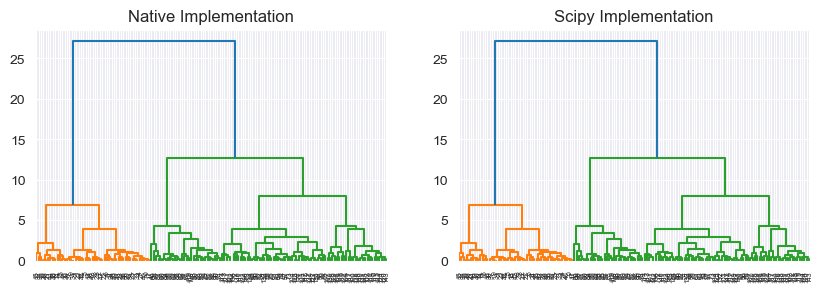

In [69]:
timers = []

t1 = time.now()
linkage_matrix, optimal_clusters = hierarchical_clustering(data_iris_scaled, 2)
timers += [(time.now() - t1).microseconds / 1000]

t1 = time.now()
linkage_matrix_scipy = hierarchy_lib.linkage(data_iris_scaled, 'ward')
timers += [(time.now() - t1).microseconds / 1000]


labels = hierarchy_lib.fcluster(linkage_matrix, 10, criterion='distance')
labels_scipy = hierarchy_lib.fcluster(linkage_matrix_scipy, 10, criterion='distance')

print("Optimal clusters: ", optimal_clusters)
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].set_title("Native Implementation")
dm0 = hierarchy_lib.dendrogram(linkage_matrix, ax=axes[0])
axes[1].set_title("Scipy Implementation")
dm1 = hierarchy_lib.dendrogram(linkage_matrix_scipy, ax=axes[1])
plt.show()

## Сравнение метрик

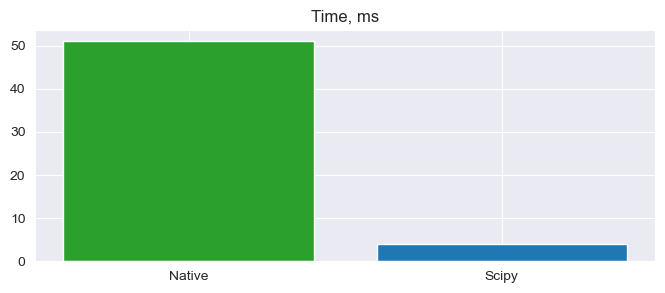

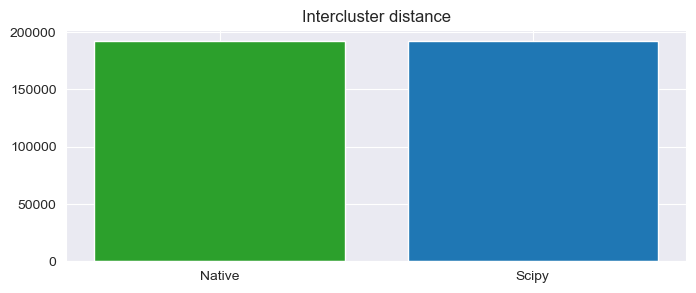

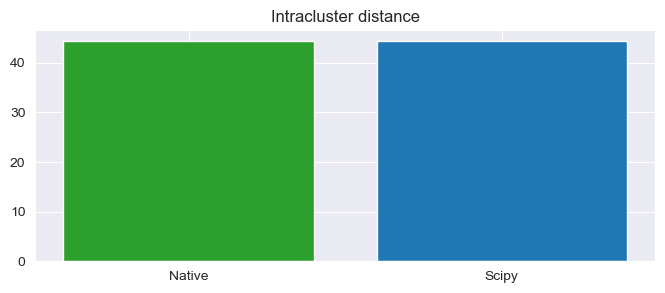

In [70]:
metrics_compairson(data_iris_scaled, labels, labels_scipy, timers)

## Кластеризация Покупателей

Optimal clusters:  5


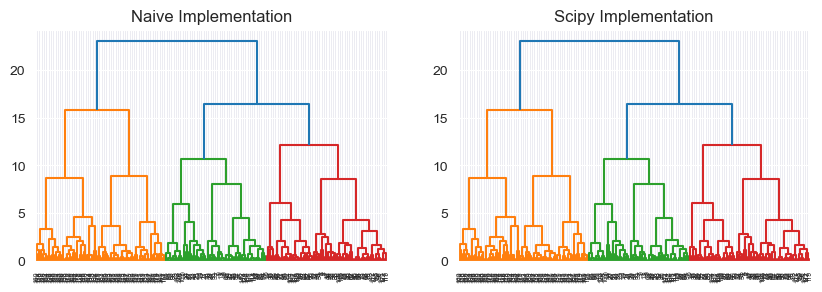

In [71]:
timers = []

t1 = time.now()
linkage_matrix, optimal_clusters = hierarchical_clustering(data_mall_scaled, 2)
timers += [(time.now() - t1).microseconds / 1000]

t1 = time.now()
linkage_matrix_scipy = hierarchy_lib.linkage(data_mall_scaled, 'ward')
timers += [(time.now() - t1).microseconds / 1000]

print("Optimal clusters: ", optimal_clusters)

labels = hierarchy_lib.fcluster(linkage_matrix, 10, criterion='distance')
labels_scipy = hierarchy_lib.fcluster(linkage_matrix_scipy, 10, criterion='distance')

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].set_title("Naive Implementation")
dm0 = hierarchy_lib.dendrogram(linkage_matrix, ax=axes[0])
axes[1].set_title("Scipy Implementation")
dm1 = hierarchy_lib.dendrogram(linkage_matrix_scipy, ax=axes[1])
plt.show()

## Сравнение метрик

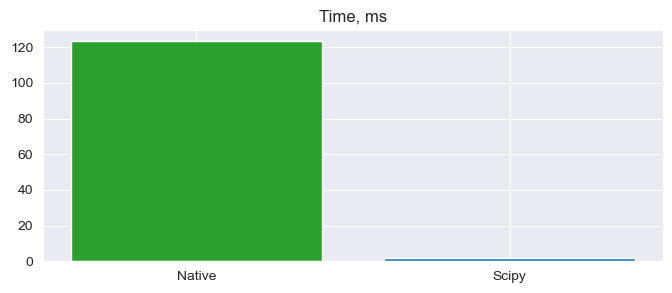

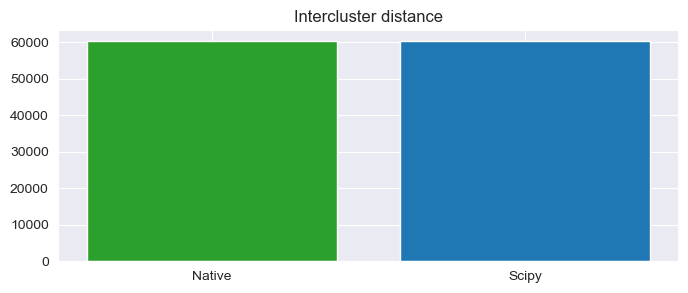

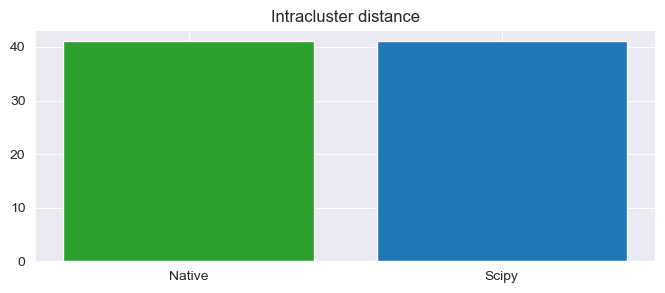

In [72]:
metrics_compairson(data_mall_scaled, labels, labels_scipy, timers)

## EM-алгоритм

In [97]:
def initialize_parameters(X, n_clusters):
    n_samples, n_features = X.shape
    means = X[np.random.choice(n_samples, n_clusters, replace=False)]
    covariances = [np.eye(n_features) for _ in range(n_clusters)]
    weights = np.full(n_clusters, 1 / n_clusters)
    return means, covariances, weights

def gaussian_pdf(x, mean, covariance, regularization=1e-6):
    d = len(mean)
    covariance += np.eye(d) * regularization
    det_cov = np.linalg.det(covariance)
    if det_cov == 0:
        raise np.linalg.LinAlgError("Ковариационная матрица вырожденная")
    inv_cov = np.linalg.inv(covariance)
    norm_const = 1 / ((2 * np.pi) ** (d / 2) * det_cov ** 0.5)
    diff = x - mean
    return norm_const * np.exp(-0.5 * diff.T @ inv_cov @ diff)

def e_step(X, means, covariances, weights):
    n_samples, n_clusters = X.shape[0], len(weights)
    responsibilities = np.zeros((n_samples, n_clusters))

    for i in range(n_samples):
        for k in range(n_clusters):
            responsibilities[i, k] = weights[k] * gaussian_pdf(X[i], means[k], covariances[k])
        responsibilities[i, :] /= np.sum(responsibilities[i, :])

    return responsibilities

def m_step(X, responsibilities):
    n_samples, n_features = X.shape
    n_clusters = responsibilities.shape[1]

    N_k = np.sum(responsibilities, axis=0)
    means = np.zeros((n_clusters, n_features))
    covariances = []
    weights = N_k / n_samples

    for k in range(n_clusters):
        means[k] = np.sum(responsibilities[:, k, None] * X, axis=0) / N_k[k]
        diff = X - means[k]
        cov_matrix = np.dot((responsibilities[:, k, None] * diff).T, diff) / N_k[k]
        covariances.append(cov_matrix)

    return means, covariances, weights

def em_algorithm(X, n_clusters, max_iter=100, tol=1e-6):
    means, covariances, weights = initialize_parameters(X, n_clusters)
    log_likelihoods = []

    for iteration in range(max_iter):
        responsibilities = e_step(X, means, covariances, weights)
        means, covariances, weights = m_step(X, responsibilities)
        log_likelihood = 0
        for i in range(X.shape[0]):
            log_likelihood += np.log(np.sum([weights[k] * gaussian_pdf(X[i], means[k], covariances[k])
                                             for k in range(n_clusters)]))
        log_likelihoods.append(log_likelihood)

        if iteration > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            break

    return means, covariances, weights, responsibilities, log_likelihoods


## Ирис

C:\Users\silve\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


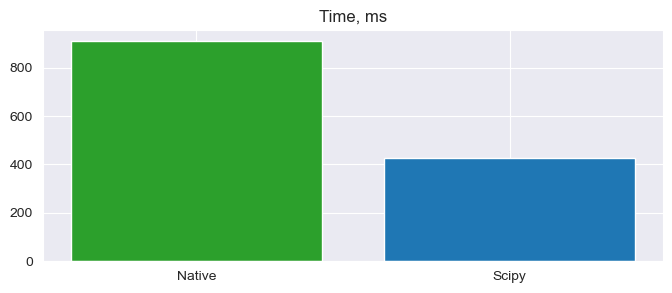

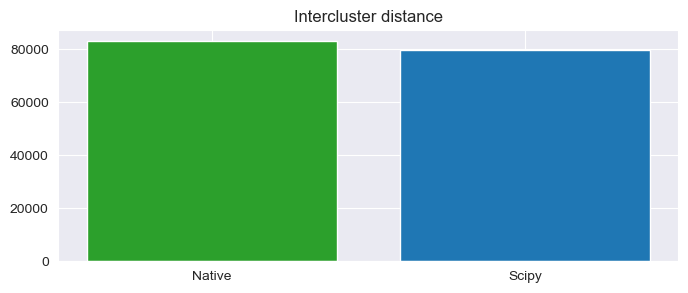

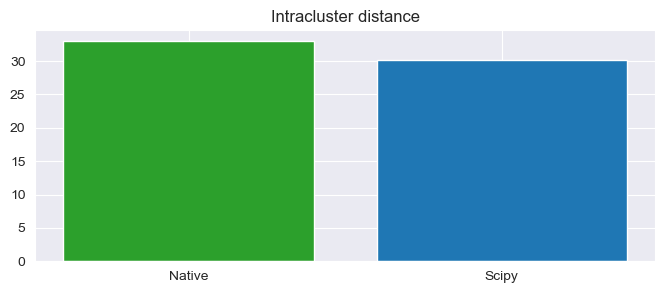

In [98]:
timers = []

num_features = 4
num_clusters = 4

t1 = time.now()
means, covariances, weights, responsibilities, log_likelihoods = em_algorithm(data_iris_scaled, num_clusters)
labels = np.argmax(responsibilities, axis=1)
t2 = time.now()
timers += [(t2 - t1).microseconds / 1000]

t1 = time.now()
labels_sklearn = GaussianMixture(n_components=num_clusters,
                     max_iter=100,
                     covariance_type='diag'
                    ).fit_predict(data_iris_scaled)

t2 = time.now()
timers += [(t2 - t1).microseconds / 1000]

metrics_compairson(data_iris_scaled, labels, labels_sklearn, timers)

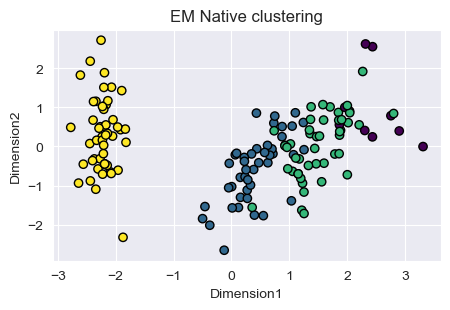

In [99]:
plot_clusters(labels, data_iris_pca_df, "EM Native clustering")

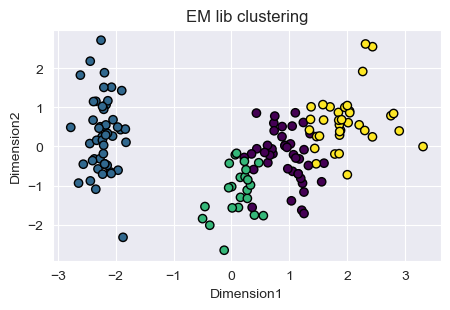

In [100]:
plot_clusters(labels_sklearn, data_iris_pca_df, "EM lib clustering")

## Покупатели

C:\Users\silve\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


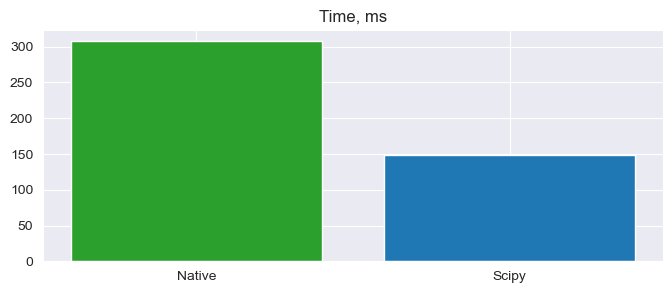

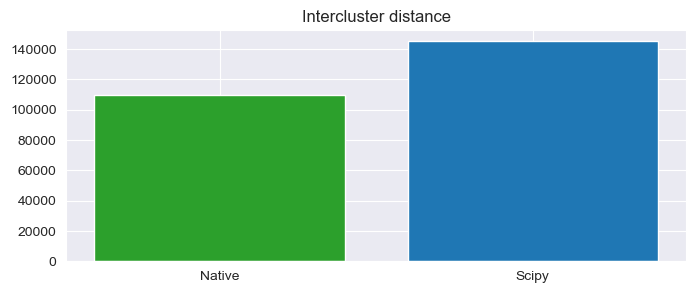

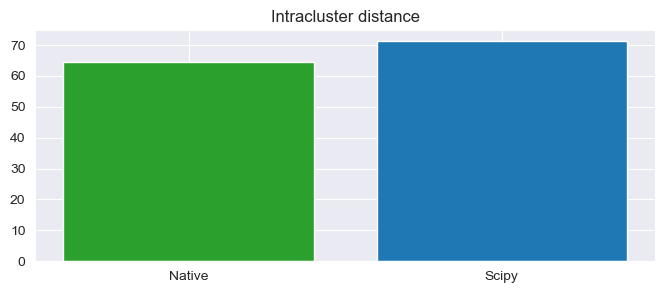

In [101]:
timers = []

num_features = 5
num_clusters = 5

t1 = time.now()
means, covariances, weights, responsibilities, log_likelihoods = em_algorithm(data_mall_scaled, num_clusters)
labels = np.argmax(responsibilities, axis=1)
t2 = time.now()
timers += [(t2 - t1).microseconds / 1000]

t1 = time.now()
labels_sklearn = GaussianMixture(n_components=num_clusters,
                     max_iter=100,
                     covariance_type='diag'
                    ).fit_predict(data_mall_scaled)

t2 = time.now()
timers += [(t2 - t1).microseconds / 1000]

metrics_compairson(data_mall_scaled, labels, labels_sklearn, timers)

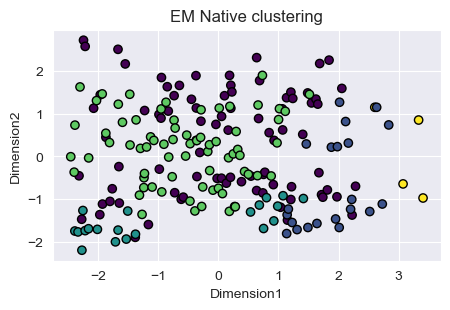

In [102]:
plot_clusters(labels, data_mall_pca_df, "EM Native clustering")

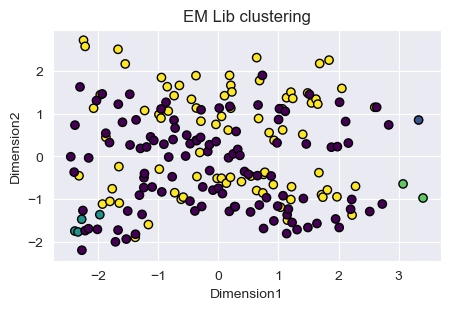

In [103]:
plot_clusters(labels_sklearn, data_mall_pca_df, "EM Lib clustering")

Text(0.5, 1.0, 'PCA')

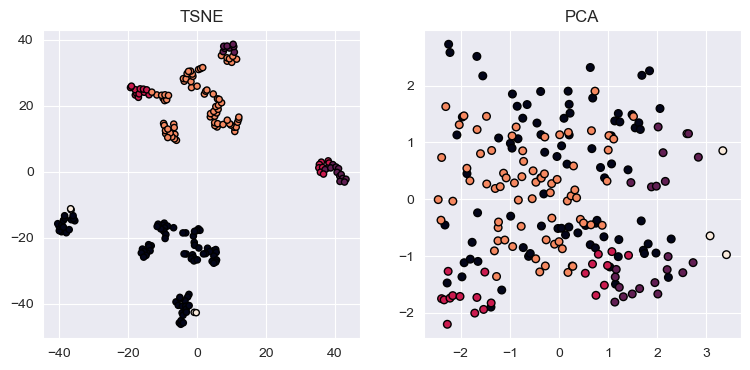

In [107]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

colors = labels.copy()
axes[0].scatter(data_mall_tsne[:, 0], data_mall_tsne[:, 1], s=20, c=colors, edgecolors='k')
axes[0].set_title("TSNE")

axes[1].scatter(data_mall_pca[:, 0], data_mall_pca[:, 1], s=30, c=colors, edgecolors='k')
axes[1].set_title("PCA")

Text(0.5, 1.0, 'PCA')

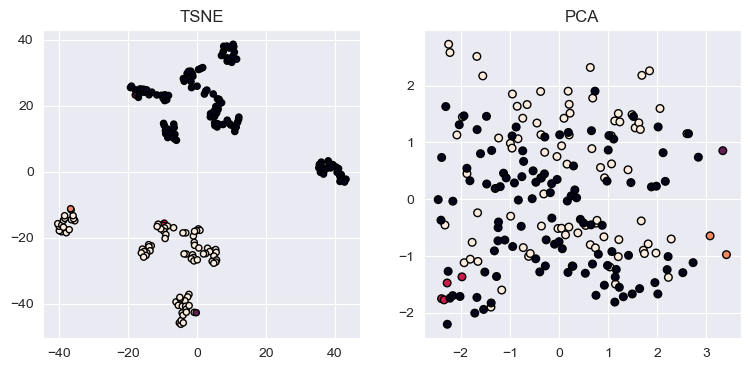

In [108]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

colors = labels_sklearn.copy()
axes[0].scatter(data_mall_tsne[:, 0], data_mall_tsne[:, 1], s=20, c=colors, edgecolors='k')
axes[0].set_title("TSNE")

axes[1].scatter(data_mall_pca[:, 0], data_mall_pca[:, 1], s=30, c=colors, edgecolors='k')
axes[1].set_title("PCA")

## DBScan

In [87]:
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

def region_query(data, point_idx, eps):
    neighbors = []
    for i in range(len(data)):
        if euclidean_distance(data[point_idx], data[i]) <= eps:
            neighbors.append(i)
    return neighbors

def expand_cluster(data, labels, point_idx, neighbors, cluster_id, eps, min_samples):
    labels[point_idx] = cluster_id
    i = 0
    while i < len(neighbors):
        neighbor_idx = neighbors[i]
        if labels[neighbor_idx] == -1:
            labels[neighbor_idx] = cluster_id
        elif labels[neighbor_idx] == 0:
            labels[neighbor_idx] = cluster_id
            neighbor_neighbors = region_query(data, neighbor_idx, eps)
            if len(neighbor_neighbors) >= min_samples:
                neighbors += neighbor_neighbors
        i += 1

def dbscan(data, eps, min_samples):
    labels = [0] * len(data)
    cluster_id = 0

    for point_idx in range(len(data)):
        if labels[point_idx] != 0:
            continue
        neighbors = region_query(data, point_idx, eps)
        if len(neighbors) < min_samples:
            labels[point_idx] = -1
        else:
            cluster_id += 1
            expand_cluster(data, labels, point_idx, neighbors, cluster_id, eps, min_samples)

    return labels

## Ирис

In [88]:
timers = []

N = len(data_iris_scaled)
epsilon = 1.5
min_samples = 15

t1 = time.now()
labels = dbscan(data_iris_scaled, epsilon, min_samples)
t2 = time.now()
timers += [(t2 - t1).microseconds / 1000]

t1 = time.now()
labels_db = DBSCAN(
    eps=epsilon,
    min_samples=min_samples,
).fit_predict(data_iris_scaled)
t2 = time.now()
timers += [(t2 - t1).microseconds / 1000]
#metrics_compairson(data_iris_scaled, labels, labels_db, timers)


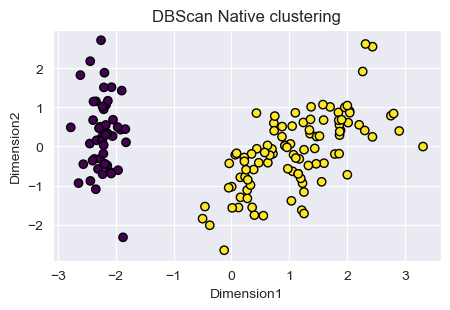

In [89]:
plot_clusters(labels, data_iris_pca_df, "DBScan Native clustering")

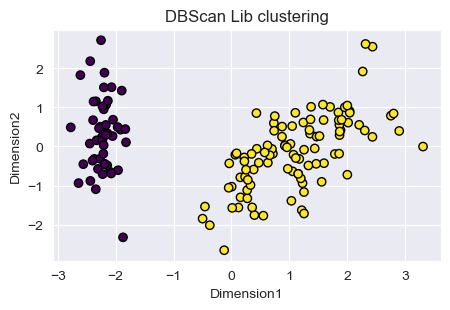

In [90]:
plot_clusters(labels_db, data_iris_pca_df, "DBScan Lib clustering")

## Покупатели

In [91]:
timers = []

N = len(data_mall_scaled)
epsilon = 1.5
min_samples = 15

t1 = time.now()
labels = dbscan(data_mall_scaled, epsilon, min_samples)
t2 = time.now()
timers += [(t2 - t1).microseconds / 1000]

t1 = time.now()
db = DBSCAN(eps=epsilon, min_samples=min_samples)
labels_db = DBSCAN(
    eps=epsilon,
    min_samples=min_samples,
).fit_predict(data_mall_scaled)
t2 = time.now()
timers += [(t2 - t1).microseconds / 1000]
#metrics_compairson(data_mall_scaled, labels, labels_db, timers)


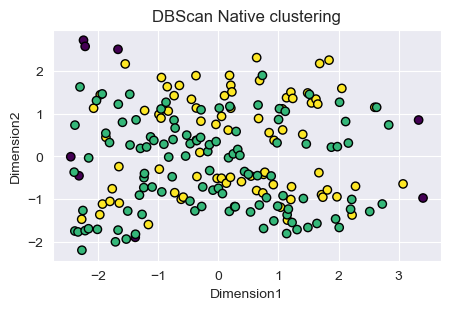

In [92]:
plot_clusters(labels, data_mall_pca_df, "DBScan Native clustering")

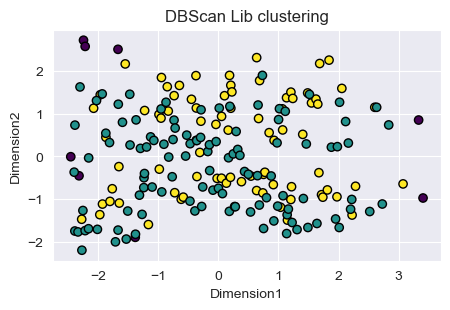

In [93]:
plot_clusters(labels_db, data_mall_pca_df, "DBScan Lib clustering")